<a href="https://colab.research.google.com/github/ranggakd/steganography/blob/main/Exploring_Steganography_In_The_Wild_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
[![Open Medium](https://gist.githubusercontent.com/ranggakd/34926ba72fa0b0c17566b0b2a52296de/raw/90dde15647e4d3e6d292f2a95612cb3bd428dcf3/medium.svg)](https://medium.com/@ranggakd)

This notebook is Google Colab compatible. Feel free to edit several parts so you could run them on your local device. More explanation available on Medium.

In [1]:
#@markdown *Last running requirement version*

!python -V
!pip freeze | grep -w 'numpy\|matplotlib\|Pillow\|scikit-learn'

Python 3.7.12
matplotlib==3.2.2
matplotlib-inline==0.1.3
matplotlib-venn==0.11.6
numpy==1.21.5
Pillow==7.1.2
scikit-learn==1.0.2


# 1️⃣Introduction

Steganography is the practice of concealing a message within another message or a physical object [1], in this case is image. There are two images in general: a cover image and an hidden image. The idea is to concealing hidden image within the lowest bits of cover image. This spesific practice is called LSB or Least-Significant Bits.

These two images we reference are raster graphic digital images, which are basically a dot matrix data structure representing a grid of pixels. When working with binary codes, we have more significant bits and less significant bits, as you can see in the image below.

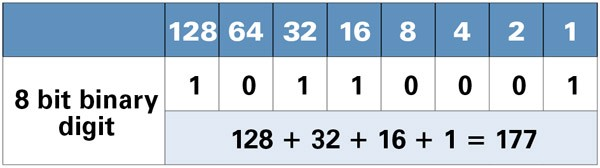

The __leftmost bit__ is __the most significant bit__. If we change the leftmost bit it will have a large impact on the final value. For example, if we change the leftmost bit from 1 to 0 (11111111 to 01111111) it will change the decimal value from 255 to 127.

On the other hand, the __rightmost bit__ is __the less significant bit__. If we change the rightmost bit it will have less impact on the final value. For example, if we change the leftmost bit from 1 to 0 (11111111 to 11111110) it will change the decimal value from 255 to 254. Note that the rightmost bit will change only 1 in a range of 256 (it represents less than 1%).

So, if we change the rightmost bits it will have a small visual impact on the final image. This is the steganography key to hide an image inside another. Change the less significant bits from an image and include the most significant bits from the other image [2].

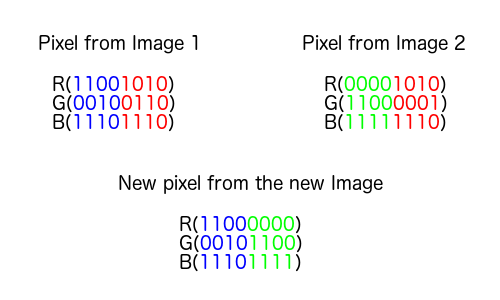

[[1] Wikipedia - Steganography](https://en.wikipedia.org/wiki/Steganography)

[[2] Steganography Hiding An Image Inside Another](https://towardsdatascience.com/steganography-hiding-an-image-inside-another-77ca66b2acb1)

In [2]:
#@markdown Import libraries {run: 'auto'}

import os
import gc
import imghdr
import random
import numpy as np
from PIL import Image
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from google.colab import files
%matplotlib inline

Saving attack titan.jpeg to attack titan.jpeg
Saving eren.jpeg to eren.jpeg
User uploaded file "attack titan.jpeg" with length 244624 bytes
User uploaded file "eren.jpeg" with length 80138 bytes


attack titan.jpeg size: (1480, 2516, 3)
eren.jpeg size: (675, 1200, 3)


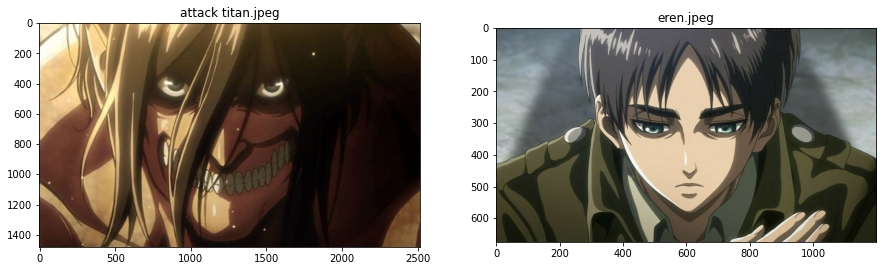

In [3]:
#@title Upload 2 custom images
#@markdown We're gonna cover one image over another. Make sure **one image which will be
#@markdown hidden** has at **most the same size** as it **cover image**

uploaded = files.upload()
image_filenames = []
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  image_filenames.append(fn)
assert len(image_filenames)==2, f"Choose 2 files at once"
print('\n')  
_, ax = plt.subplots(1, 2, figsize=(15, 15))
for i in range(2):
    image = plt.imread(image_filenames[i])
    print(f"{image_filenames[i]} size: {image.shape}")
    ax[i].imshow(image)
    ax[i].set_title(image_filenames[i])

In [4]:
#@title Choose which one is the cover {run: 'auto'}
#@markdown One for the **cover image**, other as the **hidden image** e.g. `koridor.jpg`

COVER_IMAGE = 'attack titan.jpeg' #@param {type: "string"}
HIDDEN_IMAGE = 'eren.jpeg' #@param {type: "string"}

assert os.path.isfile(COVER_IMAGE), f"There's no file named {COVER_IMAGE}"
assert os.path.isfile(HIDDEN_IMAGE), f"There's no file named {HIDDEN_IMAGE}"
assert COVER_IMAGE != HIDDEN_IMAGE, f"{COVER_IMAGE} and {HIDDEN_IMAGE} cannot be the same image"
ci_img = plt.imread(COVER_IMAGE).shape
hi_img = plt.imread(HIDDEN_IMAGE).shape
assert ci_img[0] >= hi_img[0] or ci_img[1] >= hi_img[1], \
    f"There's at least one dimension of hidden image is greater than cover image. Try the other way around."
print(f'{HIDDEN_IMAGE} could be hidden inside {COVER_IMAGE} 😉👌')

eren.jpeg could be hidden inside attack titan.jpeg 😉👌


In [5]:
#@markdown Mapping **binary values** with their corresponding **left half bits values** (*extract the left half bits values of cover image from merged image*)

PIXEL_LIMIT = 256
ZERO_BINARY = '0000'
d = {}
for i in range(PIXEL_LIMIT):
    four_bits = np.binary_repr(i).zfill(8)[0:4]
    new_val = int(four_bits + ZERO_BINARY, 2)
    d.update({i: new_val})

for k, v in d.items():
    print(f'{k}\t{np.binary_repr(k).zfill(8)}', end='\t➡\t')
    print(f'{v}\t{np.binary_repr(v).zfill(8)}')

0	00000000	➡	0	00000000
1	00000001	➡	0	00000000
2	00000010	➡	0	00000000
3	00000011	➡	0	00000000
4	00000100	➡	0	00000000
5	00000101	➡	0	00000000
6	00000110	➡	0	00000000
7	00000111	➡	0	00000000
8	00001000	➡	0	00000000
9	00001001	➡	0	00000000
10	00001010	➡	0	00000000
11	00001011	➡	0	00000000
12	00001100	➡	0	00000000
13	00001101	➡	0	00000000
14	00001110	➡	0	00000000
15	00001111	➡	0	00000000
16	00010000	➡	16	00010000
17	00010001	➡	16	00010000
18	00010010	➡	16	00010000
19	00010011	➡	16	00010000
20	00010100	➡	16	00010000
21	00010101	➡	16	00010000
22	00010110	➡	16	00010000
23	00010111	➡	16	00010000
24	00011000	➡	16	00010000
25	00011001	➡	16	00010000
26	00011010	➡	16	00010000
27	00011011	➡	16	00010000
28	00011100	➡	16	00010000
29	00011101	➡	16	00010000
30	00011110	➡	16	00010000
31	00011111	➡	16	00010000
32	00100000	➡	32	00100000
33	00100001	➡	32	00100000
34	00100010	➡	32	00100000
35	00100011	➡	32	00100000
36	00100100	➡	32	00100000
37	00100101	➡	32	00100000
38	00100110	➡	32	00100000
39	00100111	

In [6]:
#@markdown Mapping **binary values** with their corresponding **right half bits values** (*extract the left half bits values of hidden image from merged image*)

d = {}
for i in range(PIXEL_LIMIT):
    four_bits = np.binary_repr(i).zfill(8)[4:8]
    new_val = int(four_bits + ZERO_BINARY, 2)
    d.update({i: new_val})

for k, v in d.items():
    print(f'{k}\t{np.binary_repr(k).zfill(8)}', end='\t➡\t')
    print(f'{v}\t{np.binary_repr(v).zfill(8)}')

0	00000000	➡	0	00000000
1	00000001	➡	16	00010000
2	00000010	➡	32	00100000
3	00000011	➡	48	00110000
4	00000100	➡	64	01000000
5	00000101	➡	80	01010000
6	00000110	➡	96	01100000
7	00000111	➡	112	01110000
8	00001000	➡	128	10000000
9	00001001	➡	144	10010000
10	00001010	➡	160	10100000
11	00001011	➡	176	10110000
12	00001100	➡	192	11000000
13	00001101	➡	208	11010000
14	00001110	➡	224	11100000
15	00001111	➡	240	11110000
16	00010000	➡	0	00000000
17	00010001	➡	16	00010000
18	00010010	➡	32	00100000
19	00010011	➡	48	00110000
20	00010100	➡	64	01000000
21	00010101	➡	80	01010000
22	00010110	➡	96	01100000
23	00010111	➡	112	01110000
24	00011000	➡	128	10000000
25	00011001	➡	144	10010000
26	00011010	➡	160	10100000
27	00011011	➡	176	10110000
28	00011100	➡	192	11000000
29	00011101	➡	208	11010000
30	00011110	➡	224	11100000
31	00011111	➡	240	11110000
32	00100000	➡	0	00000000
33	00100001	➡	16	00010000
34	00100010	➡	32	00100000
35	00100011	➡	48	00110000
36	00100100	➡	64	01000000
37	00100101	➡	80	01010000
38	0010

In [7]:
#@markdown Mapping **binary values** with their possible **right half bits values** (*construct the right half bits values of unmerged left half bits image*)

d = {}
for i in range(PIXEL_LIMIT):
    four_bits = np.binary_repr(i).zfill(8)[0:4]
    new_val = int(four_bits + ZERO_BINARY, 2)
    d.update({new_val: [i]}) if d.get(new_val) is None else d[new_val].append(i)

for k, v in d.items():
    print(f'{k}\t{np.binary_repr(k).zfill(8)}', end='')
    for i, p in enumerate(v):
        if i == 0:
            prefix = '\t➡\t'
        else:
            prefix = '\t\t\t➡\t'
        print(f'{prefix}{p}\t{np.binary_repr(p).zfill(8)}')

0	00000000	➡	0	00000000
			➡	1	00000001
			➡	2	00000010
			➡	3	00000011
			➡	4	00000100
			➡	5	00000101
			➡	6	00000110
			➡	7	00000111
			➡	8	00001000
			➡	9	00001001
			➡	10	00001010
			➡	11	00001011
			➡	12	00001100
			➡	13	00001101
			➡	14	00001110
			➡	15	00001111
16	00010000	➡	16	00010000
			➡	17	00010001
			➡	18	00010010
			➡	19	00010011
			➡	20	00010100
			➡	21	00010101
			➡	22	00010110
			➡	23	00010111
			➡	24	00011000
			➡	25	00011001
			➡	26	00011010
			➡	27	00011011
			➡	28	00011100
			➡	29	00011101
			➡	30	00011110
			➡	31	00011111
32	00100000	➡	32	00100000
			➡	33	00100001
			➡	34	00100010
			➡	35	00100011
			➡	36	00100100
			➡	37	00100101
			➡	38	00100110
			➡	39	00100111
			➡	40	00101000
			➡	41	00101001
			➡	42	00101010
			➡	43	00101011
			➡	44	00101100
			➡	45	00101101
			➡	46	00101110
			➡	47	00101111
48	00110000	➡	48	00110000
			➡	49	00110001
			➡	50	00110010
			➡	51	00110011
			➡	52	00110100
			➡	53	00110101
			➡	54	00110110
			➡	55	00110111
			➡	56	00111000
			➡	5

In [8]:
#@markdown Helper function definition

def get_bits_dict(start: int, end: int, recon: bool = False) -> Dict[int, int]:
    bits_dict = {}
    s = slice(start, end)
    for i in range(256):
        four_bits = np.binary_repr(i).zfill(8)[s]
        new_val = int(four_bits + '0000', 2)
        if not recon:
            bits_dict.update({i: new_val})
        else:
            if bits_dict.get(new_val) is None:
                bits_dict.update({new_val: [i]})
            else:
                bits_dict[new_val].append(i)
    return bits_dict

lhb = get_bits_dict(0, 4)   # Left half bits dict lookup
rhb = get_bits_dict(4, 8)   # Right half bits dict lookup
rrhb = get_bits_dict(0, 4, recon=True)  # Reconstruction right half bits dict lookup

In [9]:
#@markdown Steganograph class definition

class Steganograph:
    '''
    A simple exploratory class to create a steganograph based on 2 images.

    Attributes
    ----------
    ispng : bool
        if True then both cover and hidden image are PNG files, otherwise False
    og_ci : numpy array
        original cover image
    og_hi : numpy array
        original hidden image
    lhb_hi : numpy array, default None
        left half bits hidden image
    merged_image : numpy array, default None
        merged image or steganograph
    ulhb_ci : numpy array, default None
        unmerged left half bits cover image
    ulhb_hi : numpy array, default None
        unmerged left half bits hidden image
    recon_ci : numpy array, default None
        reconstructed cover image
    recon_hi : numpy array, default None
        reconstructed hidden image    

    Methods
    -------
    encode(pos: str = 'upper_left'):
        Create a simple steganograph.
    decode(pos: str = 'upper_left'):
        Break down a simple steganograph.
    encode_decode(pos: str = 'upper_left'):
        Create a simple steganograph then break it down.
    reconstruct():
        Reconstruct unmerged left half bits images by manipulation their right half bits.
    encode_decode_recon(pos: str = 'upper_left'):
        Create a simple steganograph, break it down, then reconstruct the right half bits of them.
    check_two_images(opt: int = 0) -> bool:
        Check whether certain image are as equal as other image.
    save_image(opt: int = 0):
        Save an image from steganograph instance.
    plot_original():
        Plot original images.
    plot_left_half_bits():
        Plot left half bits hidden image.
    plot_merged_image():
        Plot merged image.
    plot_unmerged_left_half_bits():
        Plot RGB, red, green and blue channel of unmerged left half bits images.
    plot_recon():
        Plot RGB, red, green and blue channel of reconstructed images.    
    '''
    __get_lhb = lhb # Left half bits dict lookup
    __get_rhb = rhb # Right half bits dict lookup
    __get_rrhb = rrhb # Reconstruction right half bits dict lookup
    __zbin = '0000' # Zero binary
    __format = ('jpeg', 'png') # Format image extension tuple
    __rgb = ('RGB', 'Red', 'Green', 'Blue') # Channel image tuple
    __pos = ('upper_left', 'upper_right', 'lower_left', 'lower_right') # Position of hidden image underneath cover image tuple
    
    def __init__(self, ci_fname: str, hi_fname: str):
        '''
        Initialize steganograph instance with file path of cover image and hidden image. The cover and hidden image must have the same format extension.
        
        Parameters
        ----------
        ci_fname : str
            a file path of cover image to be read (only support jpeg or png)
        hi_fname : str
            a file path of hidden image to be read (only support jpeg or png)
        '''
        format_ci = imghdr.what(ci_fname).lower()
        format_hi = imghdr.what(hi_fname).lower()
        assert format_ci in self.__format and format_hi in self.__format, \
        f'Either {ci_fname!r} or {hi_fname!r} is not one of {self.__format!r}'
        assert format_ci == format_hi, \
        f'The cover ({format_ci!r}) and hidden ({format_hi!r}) image must have the same format extension'
        self.ispng = True if format_ci == 'png' else False
        self.og_ci = plt.imread(ci_fname)
        self.og_hi = plt.imread(hi_fname)
        if self.ispng:
            if self.og_ci.shape[-1] != 3:
                self.og_ci = np.round(self.og_ci[:,:,:-1]*255) #ignore the A channel for now
            else:
                self.og_ci = np.round(self.og_ci*255)
            if self.og_hi.shape[-1] != 3:
                self.og_hi = np.round(self.og_hi[:,:,:-1]*255) #ignore the A channel for now
            else:
                self.og_hi = np.round(self.og_hi*255)
            self.og_ci = self.og_ci.astype('uint8')
            self.og_hi = self.og_hi.astype('uint8')
        self.lhb_hi = None
        self.merged_image = None
        self.ulhb_ci = None
        self.ulhb_hi = None
        self.recon_ci = None
        self.recon_hi = None
        del format_ci, format_hi

    def __repr__(self):
        '''Return all instance attribute values at current state.'''
        output = f'Steganograph:\n'
        for (attr, val) in vars(self).items():
            if val is None or isinstance(val, bool):
                output += f'{attr}: {val}\n'
            else:
                output += f'{attr}: {val.shape} {val.dtype}\n'
        return output

    def get_left_half_bits_value(self, img_arr: np.ndarray) -> int:
        '''A vectorized function which returns a left half bits of one value.'''
        return self.__get_lhb[img_arr]

    def get_right_half_bits_value(self, img_arr: np.ndarray) -> int:
        '''A vectorized function which returns a right half bits of one value.'''
        return self.__get_rhb[img_arr]

    def merge_two_half_bits_value(self, ci_arr: np.ndarray, 
                                  hi_arr: np.ndarray) -> int:
        '''A vectorized function which return a merged value from two half bits.'''
        lhb_ci = np.binary_repr(ci_arr).zfill(8)[:4]
        lhb_hi = np.binary_repr(hi_arr).zfill(8)[:4]
        new_val = int(lhb_ci + lhb_hi, 2)
        del lhb_ci, lhb_hi
        return new_val

    def reconstruct_right_half_bits_value(self, img_arr: np.ndarray) -> int:
        '''A vectorized function which returns a reconstructed right half bits of one value.'''
        return random.choice(self.__get_rrhb[img_arr])

    def plot_images(self, kind: str, ci_arr: np.ndarray, hi_arr: np.ndarray):
        '''Plot RGB, red, green and blue channel of 2 images.'''
        im_arr_tuple = (ci_arr, hi_arr)
        _, ax = plt.subplots(len(im_arr_tuple), len(self.__rgb), figsize=(20, 7))
        for i, im in enumerate(im_arr_tuple):
            for j in range(len(self.__rgb)):
                if j == 0:
                    # RGB image
                    img = im
                else:
                    # red, green or blue only image
                    img = np.zeros(im.shape, dtype='uint8')
                    img[:,:,j-1] = im[:,:,j-1]
                image_kind = 'Cover' if i == 0 else 'Hidden'
                ax[i, j].imshow(img)
                ax[i, j].set_title(f'{self.__rgb[j]} of {kind} {image_kind} image')
        plt.tight_layout()
        del _, im_arr_tuple, ax, i, im, j, img, image_kind

    def plot_image(self, kind: str, img_arr: np.ndarray):
        '''Plot RGB, red, green and blue channel of an image.'''
        _, ax = plt.subplots(1, len(self.__rgb), figsize=(20, 10))
        for j in range(len(self.__rgb)):
            if j == 0:
                # RGB image
                img = img_arr
            else:
                # red, green or blue only image
                img = np.zeros(img_arr.shape, dtype='uint8')
                img[:,:,j-1] = img_arr[:,:,j-1]
            ax[j].imshow(img)
            ax[j].set_title(f'{self.__rgb[j]} of {kind} image')
        plt.tight_layout()
        del _, ax, j, img

    def construct_new_lhb_hi(self, hi_arr: np.ndarray, new_hi_arr: np.ndarray,
                             pos: str) -> np.ndarray:
        '''Construct a new left half bits of hidden image with the size of cover image based on certain position.'''
        row_threshold, col_threshold, _ = hi_arr.shape
        # default on position (0, 0)
        if pos == 'upper_left':
            new_hi_arr[:row_threshold, :col_threshold, :] = hi_arr
        del _, row_threshold, col_threshold, pos, hi_arr
        new_hi_arr = new_hi_arr.astype('uint8')
        return new_hi_arr

    def construct_new_rhb_mi(self, mi_arr: np.ndarray, hi_arr: np.ndarray,
                             pos: str) -> np.ndarray:
        '''Construct a new right half bits of merged image with the size of hidden image based on certain position.'''
        row_threshold, col_threshold, _ = hi_arr.shape
        # default on position (0, 0)
        if pos == 'upper_left':
            hi_arr = mi_arr[:row_threshold, :col_threshold, :]
        del _, row_threshold, col_threshold, pos, mi_arr
        hi_arr = hi_arr.astype('uint8')
        return hi_arr

    def get_left_half_bits(self, im_arr: np.ndarray) -> np.ndarray:
        '''Construct a left half bits only image of an image.'''
        vf = np.vectorize(self.get_left_half_bits_value)
        return vf(im_arr).astype('uint8')

    def get_right_half_bits(self, im_arr: np.ndarray) -> np.ndarray:
        '''Construct a right half bits only image of an image.'''
        vf = np.vectorize(self.get_right_half_bits_value)
        return vf(im_arr).astype('uint8')

    def merge_two_half_bits(self, pos: str):
        '''Merge two half bits images.'''
        new_lhb_hi = np.zeros(self.og_ci.shape, dtype='uint8')
        # assign left half bits hidden image into an array size of cover image
        new_lhb_hi = self.construct_new_lhb_hi(self.lhb_hi, new_lhb_hi, pos)
        vf = np.vectorize(self.merge_two_half_bits_value)
        # assign new left half bits hidden image into subarray of cover image
        self.merged_image = vf(self.og_ci.copy(), new_lhb_hi).astype('uint8')
        del new_lhb_hi, vf

    def reconstruct_right_half_bits(self, im_arr: np.ndarray) -> np.ndarray:
        '''Reconstruct the right half bits of unmerged image with random sampling.'''
        vf = np.vectorize(self.reconstruct_right_half_bits_value)
        return vf(im_arr).astype('uint8')

    def unmerge(self, pos: str):
        '''Unmerge image into a separate two half bits images.'''
        temp_ulhb_hi = np.zeros(self.merged_image.shape, dtype='uint8')
        self.ulhb_hi = np.zeros(self.lhb_hi.shape, dtype='uint8')
        # assign new left and right half bits into different array
        self.ulhb_ci = self.get_left_half_bits(self.merged_image)
        temp_ulhb_hi = self.get_right_half_bits(self.merged_image)
        # assign new right half bits merged image into an array size of hidden image
        self.ulhb_hi = self.construct_new_rhb_mi(temp_ulhb_hi, self.ulhb_hi, pos)
        del temp_ulhb_hi

    def encode(self, pos: str = 'upper_left'):
        '''
        Create a simple steganograph.
        
        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'
        '''
        if pos not in self.__pos:
            raise ValueError(
                f'Expected {pos!r} is one of {self.__pos!r}')
        self.lhb_hi = self.get_left_half_bits(self.og_hi)
        self.merge_two_half_bits(pos)
        gc.collect()

    def decode(self, pos: str = 'upper_left'):
        '''
        Break down a simple steganograph.

        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'
        '''
        if self.merged_image is None:
            raise TypeError(
                f'Merged image cannot be None. Expected to run encode() first')
        if pos not in self.__pos:
            raise ValueError(
                f'Expected {pos!r} is one of {self.__pos!r}')
        self.unmerge(pos)
        gc.collect()

    def encode_decode(self, pos: str = 'upper_left'):
        '''
        Create a simple steganograph then break it down.

        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'        
        '''
        self.encode(pos)
        self.decode(pos)

    def reconstruct(self):
        '''Reconstruct unmerged left half bits images by manipulation their right half bits.'''
        if self.ulhb_ci is None or self.ulhb_hi is None:
            raise TypeError(
                f'Either unmerged left half bits cover or hidden image is None. Expected to run decode() first')
        self.recon_ci = self.reconstruct_right_half_bits(self.ulhb_ci)
        self.recon_hi = self.reconstruct_right_half_bits(self.ulhb_hi)

    def encode_decode_recon(self, pos: str = 'upper_left'):
        '''
        Create a simple steganograph, break it down, then reconstruct the right half bits of them.
        
        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'
        '''
        self.encode_decode(pos)
        self.reconstruct()

    def error(self, img_arr1: np.ndarray,
              img_arr2: np.ndarray) -> Tuple[float, float]:
        '''Calculate two images differences by RMSE and MAE.'''
        rmse = mean_squared_error(img_arr1.ravel(), img_arr2.ravel(), 
                                  squared=False)
        mae = mean_absolute_error(img_arr1.ravel(), img_arr2.ravel())
        return (rmse, mae)
    
    def check_option(self, opt: int) -> Tuple[np.ndarray, np.ndarray]:
        '''Switch-case dictionary like function to choose images option.'''
        return {
            # cover image
            0: lambda: (self.og_ci, self.ulhb_ci),
            1: lambda: (self.og_ci, self.recon_ci),
            2: lambda: (self.ulhb_ci, self.recon_ci),
            3: lambda: (self.merged_image, self.og_ci),
            4: lambda: (self.merged_image, self.ulhb_ci),
            5: lambda: (self.merged_image, self.recon_ci),
            # hidden image
            6: lambda: (self.og_hi, self.ulhb_hi),
            7: lambda: (self.og_hi, self.recon_hi),
            8: lambda: (self.ulhb_hi, self.recon_hi),
            9: lambda: (self.lhb_hi, self.og_hi),
            10: lambda: (self.lhb_hi, self.ulhb_hi),
            11: lambda: (self.lhb_hi, self.recon_hi)
        }.get(opt, lambda: None)()

    def check_two_images(self, opt: int = 0) -> Tuple[bool, float, float]:
        '''
        Check whether certain image are as equal as other image.
        
        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
            11 : left half bits hidden image <-> reconstructed hidden image
        '''
        if opt < 0 or opt > 11:
            raise ValueError(f'Expected {opt!r} to be between 0 and 11 inclusively')
        img_arr1, img_arr2 = self.check_option(opt)
        if img_arr1 is None or img_arr2 is None:
            raise TypeError(f'Either one of two images is None')
        rmse, mae = self.error(img_arr1, img_arr2)
        if np.array_equal(img_arr1, img_arr2):
            return (True, rmse, mae)
        else:
            return (False, rmse, mae)

    def save_option(self, opt: int) -> Tuple[np.ndarray, str]:
        '''Switch-case dictionary like function to choose which image to save.'''
        return {
            # original images
            0: lambda: (self.og_ci, 'Original Cover Image'),
            1: lambda: (self.og_hi, 'Original Hidden Image'),
            # left half bits image
            2: lambda: (self.lhb_hi, 'Left Half Bits Hidden Image'),
            # merged image
            3: lambda: (self.merged_image, 'Merged Image'),
            # unmerged left half bits images
            4: lambda: (self.ulhb_ci, 'Unmerged Left Half Bits Cover Image'),
            5: lambda: (self.ulhb_hi, 'Unmerged Left Half Bits Hidden Image'),
            # reconstructed images
            6: lambda: (self.recon_ci, 'Reconstructed Cover Image'),
            7: lambda: (self.recon_hi, 'Reconstructed Hidden Image')
        }.get(opt, lambda: None)()

    def save_image(self, opt: int = 0):
        '''
        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        '''
        if opt < 0 or opt > 7:
            raise ValueError(f'Expected {opt!r} to be between 0 and 7 inclusively')
        img_arr, filename = self.save_option(opt)
        if img_arr is None:
            raise TypeError(f'The images is None')
        img_obj = Image.fromarray(img_arr)
        if self.ispng:
            img_obj.save(f'{filename}.png')
        else:
            img_obj.save(f'{filename}.jpg', quality=100, subsampling=0)
        del img_arr, filename, img_obj
        gc.collect()

    def plot_original(self):
        '''Plot original images.'''
        self.plot_images('Original', self.og_ci, self.og_hi)

    def plot_left_half_bits(self):
        '''Plot left half bits hidden image.'''
        if self.lhb_hi is None:
            raise TypeError(f'Left half bits hidden image cannot be None. Expected to run encode() first')
        self.plot_image('Left Half Bits Hidden', self.lhb_hi)

    def plot_merged_image(self):
        '''Plot merged image.'''
        if self.merged_image is None:
            raise TypeError(f'Merged image cannot be None. Expected to run encode() first')
        self.plot_image('Merged', self.merged_image)

    def plot_unmerged_left_half_bits(self):
        '''Plot RGB, red, green and blue channel of unmerged left half bits images.'''
        if self.ulhb_ci is None or self.ulhb_hi is None:
            raise TypeError(f'Either unmerged left half bits cover or hidden image is None. Expected to run decode() first')
        self.plot_images('Unmerged Left Half Bits', self.ulhb_ci, self.ulhb_hi)

    def plot_recon(self):
        '''Plot RGB, red, green and blue channel of reconstructed images.'''
        if self.recon_ci is None and self.recon_hi is None:
            raise TypeError(f'Either reconstructed cover or hidden image is None. Expected to run reconstruct() first')
        self.plot_images('Reconstructed', self.recon_ci, self.recon_hi)

In [10]:
#@title Steganograpah instantiation

sg = Steganograph(COVER_IMAGE, HIDDEN_IMAGE)
sg

Steganograph:
ispng: False
og_ci: (1480, 2516, 3) uint8
og_hi: (675, 1200, 3) uint8
lhb_hi: None
merged_image: None
ulhb_ci: None
ulhb_hi: None
recon_ci: None
recon_hi: None

In [11]:
#@markdown What to explore from the instance

print(sg.__doc__)


    A simple exploratory class to create a steganograph based on 2 images.

    Attributes
    ----------
    ispng : bool
        if True then both cover and hidden image are PNG files, otherwise False
    og_ci : numpy array
        original cover image
    og_hi : numpy array
        original hidden image
    lhb_hi : numpy array, default None
        left half bits hidden image
    merged_image : numpy array, default None
        merged image or steganograph
    ulhb_ci : numpy array, default None
        unmerged left half bits cover image
    ulhb_hi : numpy array, default None
        unmerged left half bits hidden image
    recon_ci : numpy array, default None
        reconstructed cover image
    recon_hi : numpy array, default None
        reconstructed hidden image    

    Methods
    -------
    encode(pos: str = 'upper_left'):
        Create a simple steganograph.
    decode(pos: str = 'upper_left'):
        Break down a simple steganograph.
    encode_decode(pos: str = 

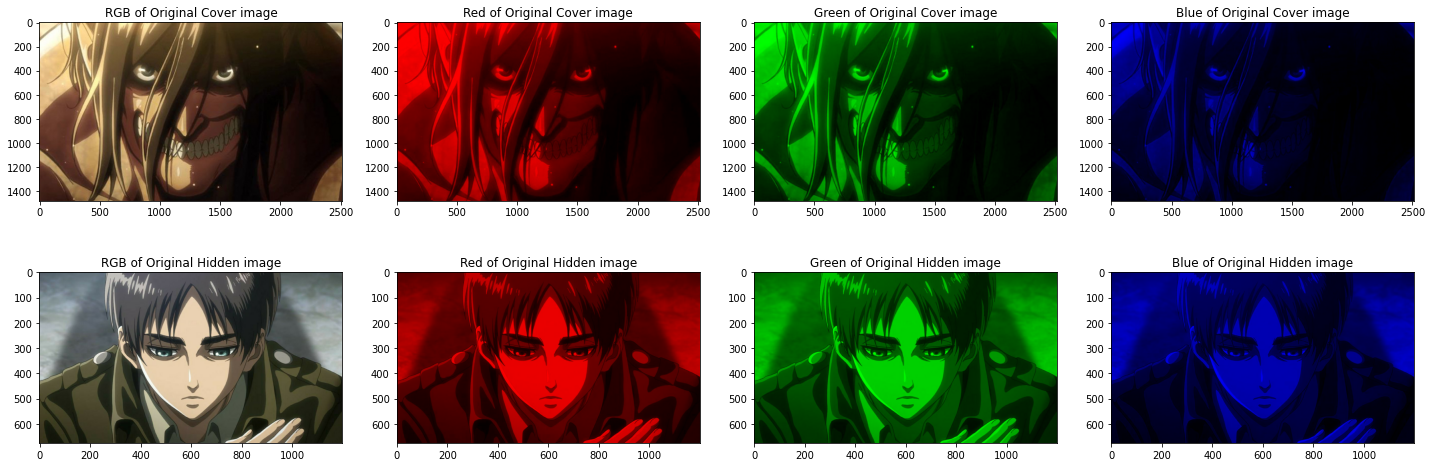

In [12]:
#@title Take a look at the cover and hidden image

sg.plot_original()

In [13]:
#@title Let's encode our first steganograph!

sg.encode()
sg

Steganograph:
ispng: False
og_ci: (1480, 2516, 3) uint8
og_hi: (675, 1200, 3) uint8
lhb_hi: (675, 1200, 3) uint8
merged_image: (1480, 2516, 3) uint8
ulhb_ci: None
ulhb_hi: None
recon_ci: None
recon_hi: None

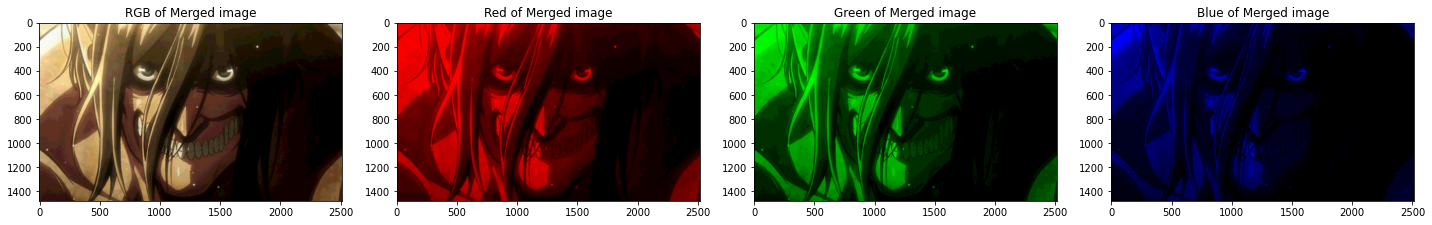

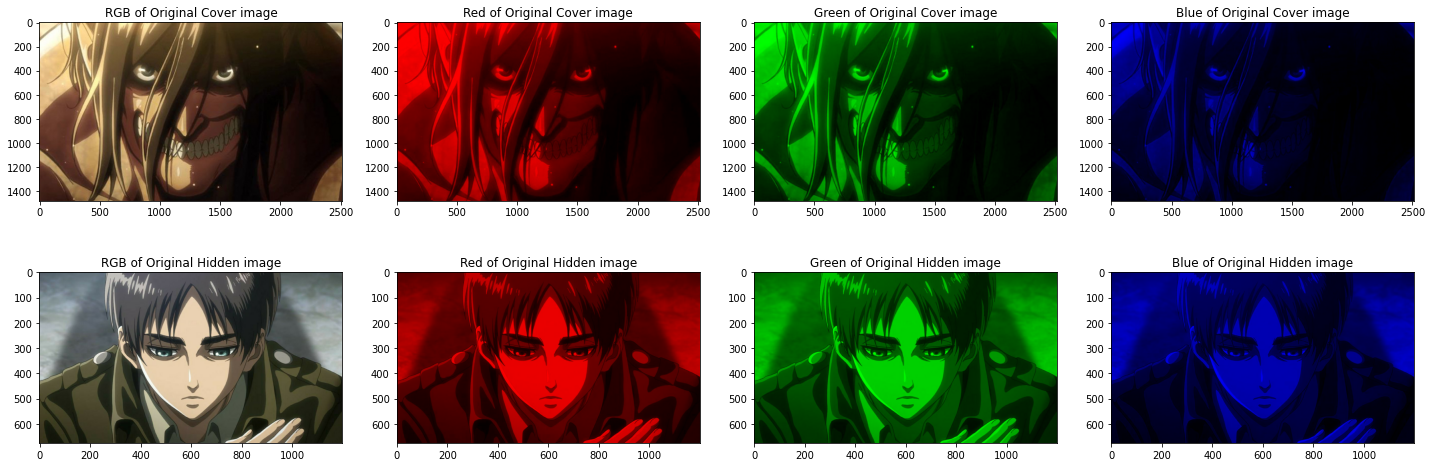

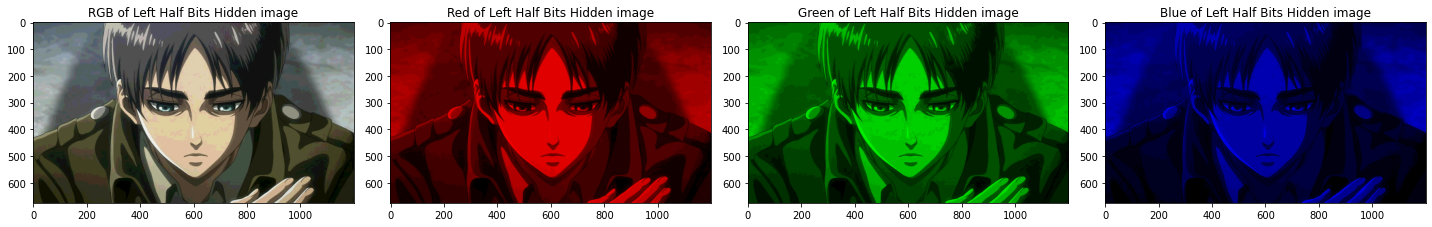

In [14]:
#@title Comparing the merged, original and left half bits hidden image visually

sg.plot_merged_image()
sg.plot_original()
sg.plot_left_half_bits()

In [15]:
#@markdown Let's save some images

print(sg.save_image.__doc__)


        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        


In [16]:
#@markdown Choose which image to save

opt = "3" #@param [0, 1, 2, 3]
sg.save_image(int(opt))

In [17]:
#@markdown Check whether the images we've seen are as equal as we expected

print(sg.check_two_images.__doc__)


        Check whether certain image are as equal as other image.
        
        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
 

In [18]:
#@title Choose what option to compare after encode {run: 'auto'}

opt = "9" #@param [3, 9]
check, rmse, mae = sg.check_two_images(int(opt))
print(f'Are they equal? {check}\nRMSE : {rmse}\nMAE : {mae}')

Are they equal? False
RMSE : 8.866986047343596
MAE : 7.5780325102880655


In [19]:
#@title Let's decode our steganograph

sg.decode()
sg

Steganograph:
ispng: False
og_ci: (1480, 2516, 3) uint8
og_hi: (675, 1200, 3) uint8
lhb_hi: (675, 1200, 3) uint8
merged_image: (1480, 2516, 3) uint8
ulhb_ci: (1480, 2516, 3) uint8
ulhb_hi: (675, 1200, 3) uint8
recon_ci: None
recon_hi: None

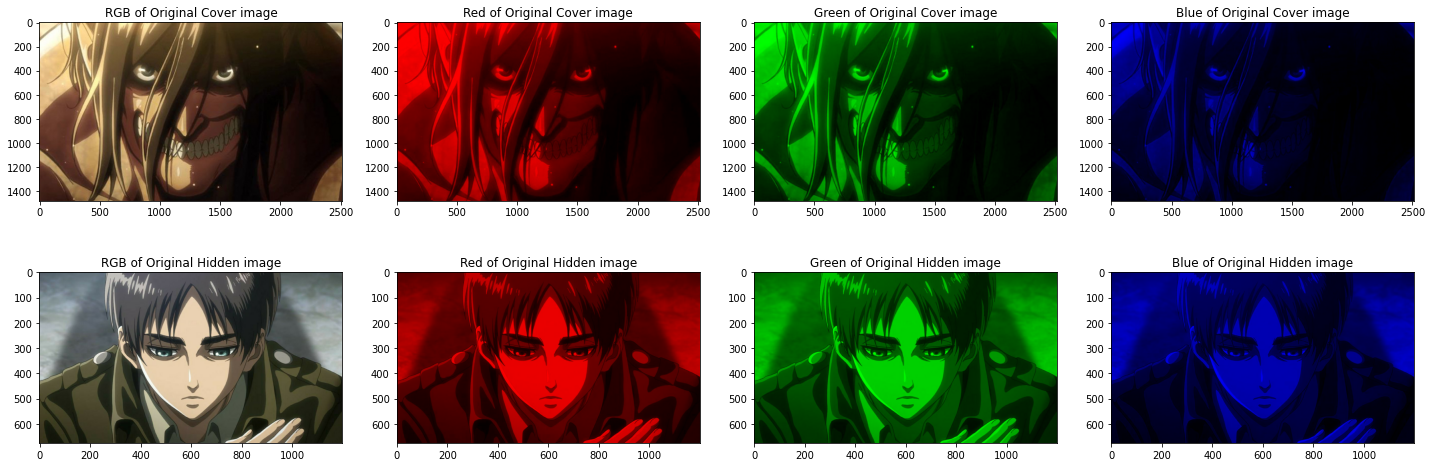

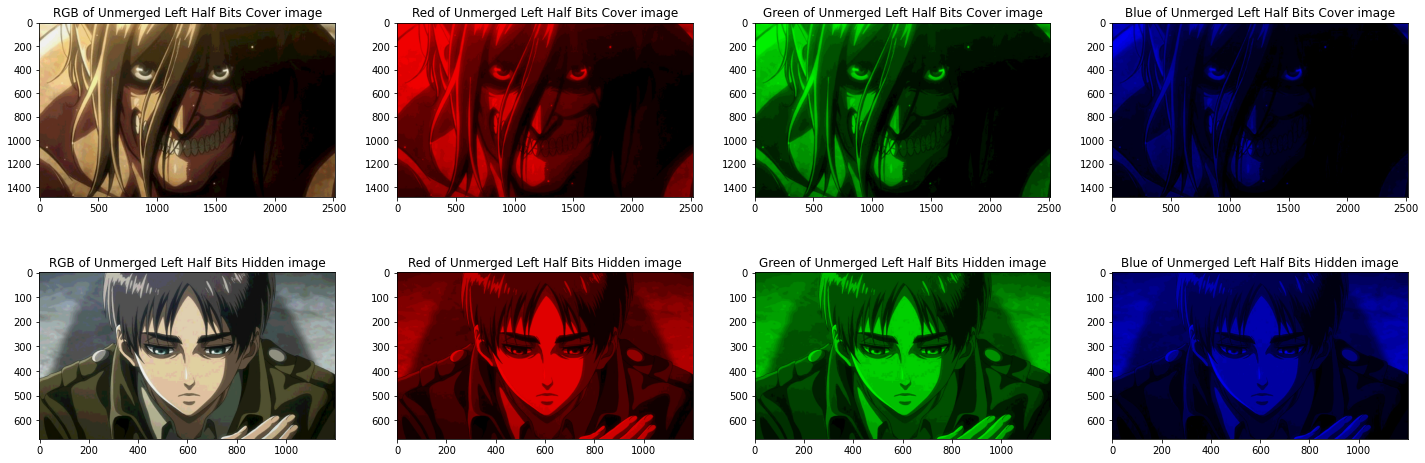

In [20]:
#@title Comparing original and unmerged left half bits images visually

sg.plot_original()
sg.plot_unmerged_left_half_bits()

In [21]:
#@markdown Let's save some images

print(sg.save_image.__doc__)


        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        


In [22]:
#@markdown Choose which image to save

opt = "4" #@param [0, 1, 2, 3, 4, 5]
sg.save_image(int(opt))

In [23]:
#@markdown Check whether the images we've seen are as equal as we expected

print(sg.check_two_images.__doc__)


        Check whether certain image are as equal as other image.
        
        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
 

In [24]:
#@title Choose what option to compare after decode {run: 'auto'}

opt = "10" #@param [0, 3, 4, 6, 9, 10]
check, rmse, mae = sg.check_two_images(int(opt))
print(f'Are they equal? {check}\nRMSE : {rmse}\nMAE : {mae}')

Are they equal? True
RMSE : 0.0
MAE : 0.0


In [25]:
#@title Let's try to reconstruct our images (right half bits manipulation)

sg.reconstruct()
sg

Steganograph:
ispng: False
og_ci: (1480, 2516, 3) uint8
og_hi: (675, 1200, 3) uint8
lhb_hi: (675, 1200, 3) uint8
merged_image: (1480, 2516, 3) uint8
ulhb_ci: (1480, 2516, 3) uint8
ulhb_hi: (675, 1200, 3) uint8
recon_ci: (1480, 2516, 3) uint8
recon_hi: (675, 1200, 3) uint8

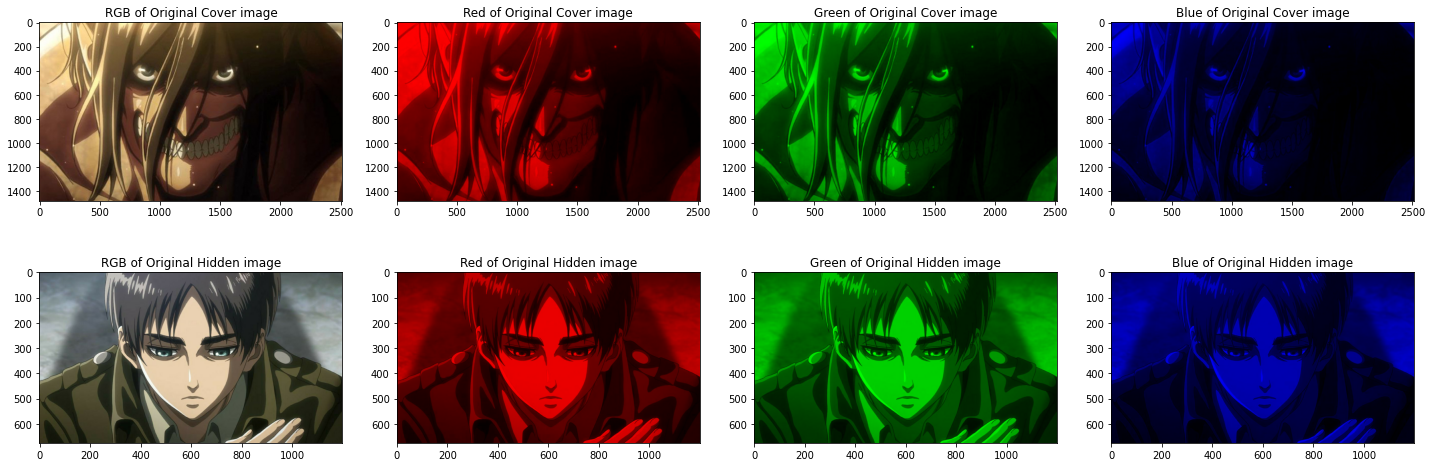

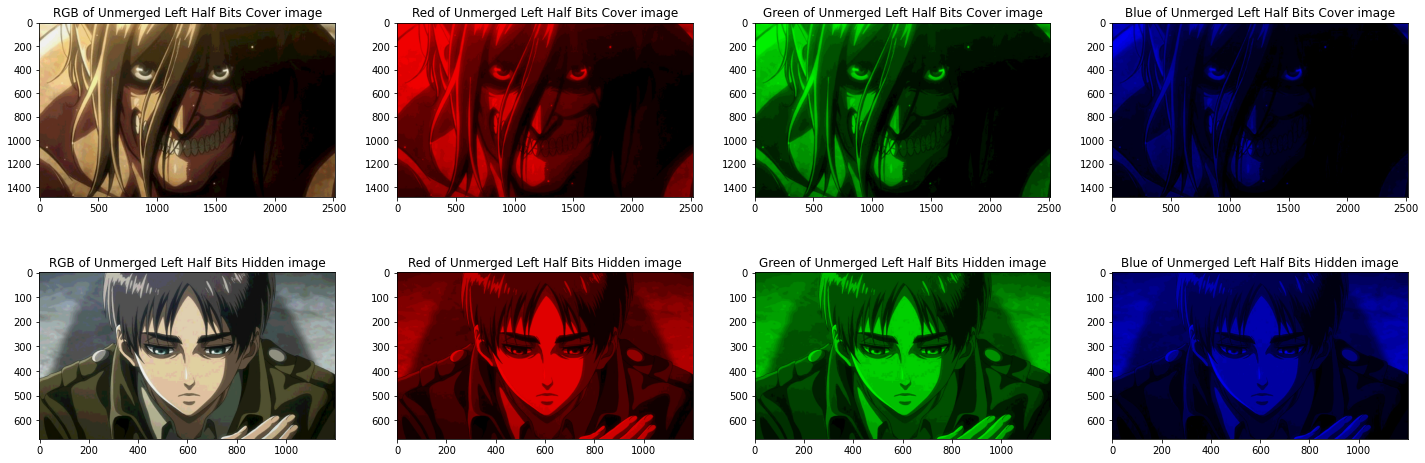

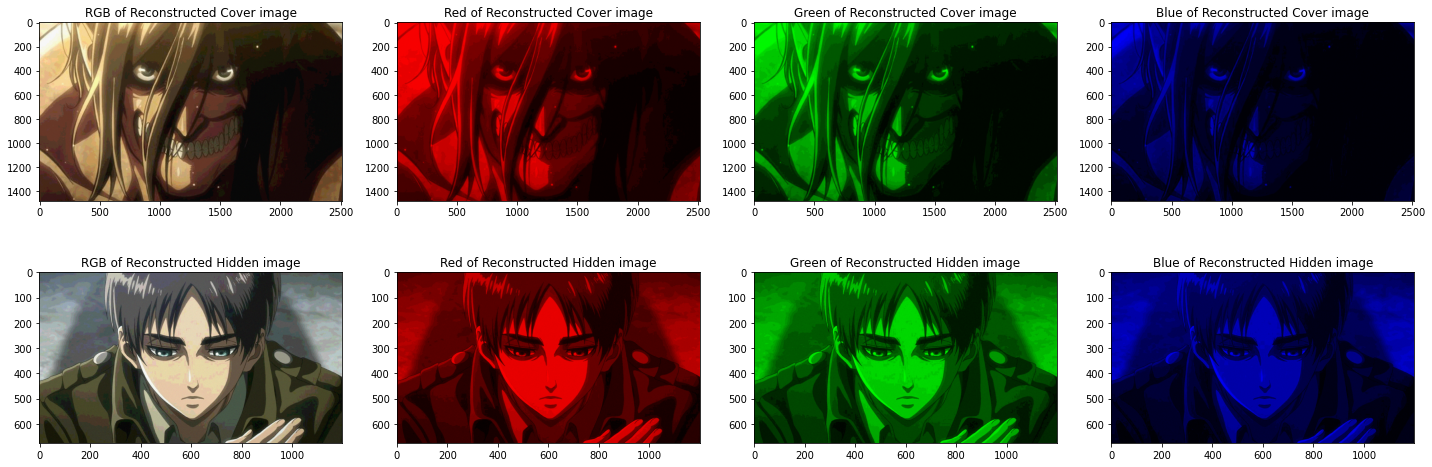

In [26]:
#@title Comparing original, unmerged left half bits and reconstructed images visually

sg.plot_original()
sg.plot_unmerged_left_half_bits()
sg.plot_recon()

In [27]:
#@markdown Let's save some images

print(sg.save_image.__doc__)


        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        


In [28]:
#@markdown Choose which image to save

opt = "6" #@param [0, 1, 2, 3, 4, 5, 6, 7]
sg.save_image(int(opt))

In [29]:
#@markdown Check whether the images we've seen are as equal as we expected

print(sg.check_two_images.__doc__)


        Check whether certain image are as equal as other image.
        
        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
 

In [30]:
#@title Choose what option to compare after decode {run: 'auto'}

opt = "5" #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
check, rmse, mae = sg.check_two_images(int(opt))
print(f'Are they equal? {check}\nRMSE : {rmse}\nMAE : {mae}')

Are they equal? False
RMSE : 8.31558500598425
MAE : 25.22104486243
